In [101]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import spearmanr
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor, IsolationForest
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.covariance import EllipticEnvelope
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
    calc_double_sharpe,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

def my_cache(func):
    def func2(*args, **kwargs):
        mem = get_joblib_memory()
        return mem.cache(func)(*args, **kwargs)
    return func2

unbiased_rank = my_cache(unbiased_rank)
    
model_name = '20221219_eda'

In [219]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC'] # binance, bybit, okex
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'AVAX'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv_spot',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
    # {
    #     'provider': 'bigquery',
    #     'options': {
    #         'table': 'bybit_ohlcv',
    #         'symbols': ['{}USDT'.format(x) for x in symbols],
    #     }
    # },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    def func1(df):
        df['symbol'] = df['symbol'].str.replace('USDT', '')
        df = df.set_index(['timestamp', 'symbol']).sort_index()
        df = df.loc[~df.index.duplicated()]
        return df
    
    df = func1(dfs[0])
    df_spot = func1(dfs[1])
    # df_bb = func1(dfs[2])
    df = df.join(df_spot, rsuffix='_spot')
    # df = df.join(df_bb, rsuffix='_bb')
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

# df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2019-12-11 08:00:00+00:00,BTCUSDT,7215.84000,7229.74000,7210.00000,7218.54000,3.122290e+03,2.254524e+07,7881.0,1497.434,...,7220.368833,7219.990833,4.639443,2.402863,7221.936333,7218.669167,1.628667,-1.638500,0.000452,2.740080e-07
1,2019-12-17 10:00:00+00:00,BTCUSDT,6880.00000,6900.00000,6879.35000,6883.22000,2.927576e+03,2.016357e+07,5668.0,1664.813,...,6885.600667,6885.395833,2.963332,2.102607,6886.725000,6884.365500,1.149167,-1.210333,0.000343,1.923972e-07
2,2019-12-03 17:00:00+00:00,BTCUSDT,7316.21000,7337.00000,7312.22000,7321.00000,1.679061e+03,1.229870e+07,5666.0,943.830,...,7323.781833,7323.251667,4.159356,2.570162,7325.851333,7321.742833,2.007833,-2.100667,0.000561,3.783585e-07
3,2019-12-16 03:00:00+00:00,BTCUSDT,7089.22000,7094.90000,7065.20000,7074.53000,2.248732e+03,1.591614e+07,4473.0,967.319,...,7082.573500,7082.660833,7.732355,2.787943,7084.162667,7081.097667,1.361500,-1.703500,0.000433,3.021363e-07
4,2019-12-11 00:00:00+00:00,BTCUSDT,7220.92000,7242.47000,7217.00000,7235.16000,2.179069e+03,1.575908e+07,4526.0,1088.284,...,7233.652000,7234.415833,4.419616,2.259133,7235.065833,7231.969000,1.601833,-1.495000,0.000428,2.257601e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236404,2020-10-23 01:00:00+00:00,MATICUSDT,0.01730,0.01743,0.01713,0.01735,2.736654e+06,4.738448e+04,403.0,1781148.000,...,0.017317,0.017313,0.000036,0.000031,0.017328,0.017307,0.000009,-0.000012,0.001204,6.741839e-06
236405,2020-10-27 02:00:00+00:00,MATICUSDT,0.01661,0.01669,0.01653,0.01656,6.780590e+05,1.124207e+04,205.0,332629.000,...,0.016598,0.016598,0.000032,0.000022,0.016603,0.016586,0.000007,-0.000010,0.001024,2.866831e-06
236406,2020-10-24 21:00:00+00:00,MATICUSDT,0.01775,0.01779,0.01756,0.01761,2.308882e+06,4.080983e+04,153.0,360636.000,...,0.017677,0.017673,0.000036,0.000020,0.017682,0.017674,0.000002,-0.000007,0.000481,1.880869e-06
236407,2020-10-27 01:00:00+00:00,MATICUSDT,0.01666,0.01669,0.01653,0.01661,1.069677e+06,1.775403e+04,178.0,159611.000,...,0.016646,0.016648,0.000024,0.000024,0.016651,0.016641,0.000002,-0.000009,0.000641,2.112393e-06


,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2019-09-14 23:00:00+00:00,ADAUSDT,0.04639,0.04650,0.04633,0.04642,549061.2,2.549819e+04,120.0,259616.3,...,0.046424,0.046431,0.000042,0.000022,0.046427,0.046421,0.000003,-0.000002,0.000111,7.662366e-08
1,2019-09-21 06:00:00+00:00,ADAUSDT,0.05313,0.05327,0.05253,0.05288,11146104.1,5.908371e+05,1899.0,5078901.0,...,0.052998,0.052989,0.000158,0.000100,0.053046,0.052956,0.000043,-0.000048,0.001715,6.636134e-06
2,2019-09-08 13:00:00+00:00,ADAUSDT,0.04649,0.04656,0.04607,0.04610,2701353.4,1.251751e+05,544.0,835101.0,...,0.046377,0.046367,0.000129,0.000043,0.046395,0.046363,0.000011,-0.000021,0.000687,1.117199e-06
3,2019-09-18 02:00:00+00:00,ADAUSDT,0.05030,0.05156,0.05025,0.05143,16580074.9,8.439398e+05,1967.0,8849695.0,...,0.050760,0.050789,0.000387,0.000066,0.050789,0.050717,0.000046,-0.000026,0.001408,4.085759e-06
4,2019-09-23 14:00:00+00:00,ADAUSDT,0.04909,0.04911,0.04790,0.04897,23042816.7,1.115863e+06,2996.0,11533516.3,...,0.048672,0.048659,0.000351,0.000133,0.048747,0.048611,0.000070,-0.000066,0.002794,1.375931e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352177,2022-09-19 15:00:00+00:00,MATICUSDT,0.76660,0.76970,0.75540,0.75950,2852337.8,2.174904e+06,7644.0,1319041.0,...,0.763502,0.763075,0.003956,0.000810,0.764117,0.762975,0.000480,-0.000662,0.001496,2.670629e-06
352178,2022-09-26 23:00:00+00:00,MATICUSDT,0.75030,0.75600,0.74980,0.75570,1202410.4,9.059393e+05,2374.0,614499.3,...,0.752988,0.753183,0.001750,0.000505,0.753228,0.752693,0.000317,-0.000218,0.000710,7.907934e-07
352179,2022-09-04 08:00:00+00:00,MATICUSDT,0.87620,0.88100,0.87180,0.87870,2188926.2,1.920407e+06,6686.0,887674.4,...,0.877993,0.878392,0.001777,0.000655,0.878388,0.877533,0.000423,-0.000432,0.000974,1.222214e-06
352180,2022-09-27 05:00:00+00:00,MATICUSDT,0.77710,0.77740,0.77140,0.77550,2313645.7,1.792504e+06,4771.0,999480.6,...,0.774925,0.774767,0.001134,0.000608,0.775338,0.774565,0.000392,-0.000382,0.000998,1.243776e-06


op          hi          lo  \
timestamp                 symbol                                       
2019-09-08 17:00:00+00:00 BTC     10000.0000  10000.0000  10000.0000   
2019-09-08 18:00:00+00:00 BTC     10000.0000  10000.0000  10000.0000   
2019-09-08 19:00:00+00:00 BTC     10000.0000  10357.5300  10000.0000   
2019-09-08 20:00:00+00:00 BTC     10340.1200  10368.6400  10334.5400   
2019-09-08 21:00:00+00:00 BTC     10351.4200  10391.9000  10324.7700   
...                                      ...         ...         ...   
2022-11-26 04:00:00+00:00 ETC        20.3650     20.4140     20.2800   
                          ETH      1215.1700   1225.0000   1213.1600   
                          LINK        6.8670      6.9020      6.8560   
                          MATIC       0.8589      0.8633      0.8572   
                          XRP         0.4084      0.4092      0.4068   

                                          cl        volume        amount  \
timestamp                 symbol                                           
2019-09-08 17:00:00+00:00 BTC     10000.0000  2.000000e-03  2.000000e+01   
2019-09-08 18:00:00+00:00 BTC     10000.0000  0.000000e+00  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC     10340.1200  4.716590e+02  4.879792e+06   
2019-09-08 20:00:00+00:00 BTC     10351.4200  5.832710e+02  6.037733e+06   
2019-09-08 21:00:00+00:00 BTC     10391.9000  6.897590e+02  7.136799e+06   
...                                      ...           ...           ...   
2022-11-26 04:00:00+00:00 ETC        20.3020  3.251792e+05  6.613859e+06   
                          ETH      1222.0900  1.789464e+05  2.181176e+08   
                          LINK        6.8930  9.829851e+05  6.762109e+06   
                          MATIC       0.8623  1.106066e+07  9.512661e+06   
                          XRP         0.4078  3.253425e+07  1.326912e+07   

                                   trades    buy_volume    buy_amount  \
timestamp                 symbol                                        
2019-09-08 17:00:00+00:00 BTC         2.0  1.000000e-03  1.000000e+01   
2019-09-08 18:00:00+00:00 BTC         0.0  0.000000e+00  0.000000e+00   
2019-09-08 19:00:00+00:00 BTC       562.0  0.000000e+00  0.000000e+00   
2019-09-08 20:00:00+00:00 BTC       731.0  3.400000e-02  3.519712e+02   
2019-09-08 21:00:00+00:00 BTC       827.0  4.000000e-03  4.138500e+01   
...                                   ...           ...           ...   
2022-11-26 04:00:00+00:00 ETC     17099.0  1.390552e+05  2.828558e+06   
                          ETH     94121.0  1.039912e+05  1.267745e+08   
                          LINK    12670.0  5.391466e+05  3.709328e+06   
                          MATIC   16602.0  6.395030e+06  5.500834e+06   
                          XRP     17771.0  1.648408e+07  6.723618e+06   

                                          twap  ...     twap_spot  \
timestamp                 symbol                ...                 
2019-09-08 17:00:00+00:00 BTC     10000.000000  ...  10376.195333   
2019-09-08 18:00:00+00:00 BTC     10000.000000  ...  10361.588167   
2019-09-08 19:00:00+00:00 BTC     10275.480000  ...  10347.438500   
2019-09-08 20:00:00+00:00 BTC     10350.826833  ...  10353.787833   
2019-09-08 21:00:00+00:00 BTC     10347.270500  ...  10351.302333   
...                                        ...  ...           ...   
2022-11-26 04:00:00+00:00 ETC        20.346017  ...     20.361833   
                          ETH      1217.087833  ...   1217.857667   
                          LINK        6.878450  ...      6.882667   
                          MATIC       0.859372  ...      0.859905   
                          XRP         0.407857  ...      0.408073   

                                  twap_5m_spot  cl_std_spot  cl_diff_std_spot  \
timestamp                 symbol                                                
2019-09-08 17:00:00+00:00 BTC     10377.110000    11.556934          6.601724   
2019-09-08 18:00:00+00:00

In [309]:
from tqdm import tqdm
from scipy.stats import kurtosis
from scipy.fft import fft, dct
from sklearn.decomposition import PCA


def calc_sparsity2(df):
    n = df.shape[0]
    X = df.values.copy()
    X -= X.mean()
    # X /= X.std()
    
    # orthogonal transform (energy preserved)
    pca = PCA()
    X = pca.fit_transform(X)
    X = fft(X, axis=0, norm='ortho')
    # X = dct(X, axis=0, norm='ortho')
    # print(X[0, :])
    X[0, :] = pca.mean_ * n ** 0.5
    
    x = np.concatenate([np.real(X[:n // 2 + 1].flatten()), np.imag(X[1:(n + 1) // 2].flatten())])
    # x = X.flatten()

    # print(x.std())
    
    # return kurtosis(x)
    return np.mean(x ** 4) / np.mean(x ** 2) ** 2

[ 4.5       -0.j          2.08155948-1.65109876j -1.83155948+1.60822041j
 -1.83155948-1.60822041j  2.08155948+1.65109876j]
[ 5.5 -0.j          2.25-0.4330127j  -2.75-1.29903811j  1.5 -0.j
 -2.75+1.29903811j  2.25+0.4330127j ]


In [409]:
from sklearn.covariance import oas, ledoit_wolf
from tqdm import tqdm
from scipy.stats import ks_2samp, kurtosis
from scipy.fft import fft, ifft, dct
from scipy.stats import entropy, differential_entropy
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor

def normal_kl(mean0, cov0, mean1, cov1):
    k = mean0.shape[0]
    mean_diff = mean1 - mean0
    cov1_inv = np.linalg.inv(cov1)
    return 0.5 * (np.trace(cov1_inv @ cov0) - k + mean_diff.T @ cov1_inv @ mean_diff + np.log(np.linalg.det(cov1) / np.linalg.det(cov0)))

# https://stats.stackexchange.com/questions/8634/jensen-shannon-divergence-for-bivariate-normal-distributions
# this is wrong
def normal_jensen_shannon(mean0, cov0, mean1, cov1):
    return normal_kl(mean0, cov0, mean1, cov1) + normal_kl(mean1, cov1, mean0, cov0)

@my_cache
def calc_dist_shift_normal_js(df):
    cv = KFold()
    rows = []
    for train_idx, test_idx in cv.split(df):
        # iloc is faster than loc
        mean0 = df.iloc[train_idx].mean()
        mean1 = df.iloc[test_idx].mean()
        cov0, _ = ledoit_wolf(df.iloc[train_idx])
        cov1, _ = ledoit_wolf(df.iloc[test_idx])
        
        div = normal_jensen_shannon(mean0, cov0, mean1, cov1)
        rows.append({
            'div': div,
        })
        
    df_result = pd.DataFrame(rows)
    return df_result
    
@my_cache
def calc_dist_shift_normal_js_single(df):
    dfs = []
    for col in tqdm(df.columns):
        df_result = calc_dist_shift_normal_js(df[[col]])
        df_result['feature'] = col
        dfs.append(df_result)
    return pd.concat(dfs)

@my_cache
def calc_dist_shift_ks_single(df):
    cv = KFold()
    rows = []
    ks_2samp_cached = my_cache(ks_2samp)
    for i in tqdm(range(df.shape[1])):
        for train_idx, test_idx in cv.split(df):  
            # iloc is faster than loc
            res = ks_2samp_cached(df.iloc[train_idx, i], df.iloc[test_idx, i])
            rows.append({
                'feature': df.columns[i],
                'ks': res[0],
            })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_symbol_dist_shift_ks_single(df):
    rows = []
    ks_2samp_cached = my_cache(ks_2samp)
    symbols = df.index.get_level_values('symbol').unique()
    for symbol, df_symbol in tqdm(df.groupby('symbol')):
        df_other = df.loc[df.index.get_level_values('symbol') != symbol]
        for i in range(df.shape[1]):
            res = ks_2samp_cached(df_other.iloc[:, i], df_symbol.iloc[:, i])
            rows.append({
                'feature': df.columns[i],
                'ks': res[0],
            })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_sparsity(df):
    # min_sphere (normal_kl(0, sphere, 0, cov))
    # 0.5 * (np.trace(cov_inv) * s - k + np.log(np.linalg.det(cov)) - k * np.log(s))
    # s: sphere radius^2
    # diff s
    # np.trace(cov_inv) - k / s = 0
    # s = k / np.trace(cov_inv)
    # 0.5 * (np.log(np.linalg.det(cov1)) - k * np.log(k / tr))
    
    # k = df.shape[1]
    # cov, _ = ledoit_wolf(df)
    # cov_inv = np.linalg.inv(cov)
    # tr = np.trace(cov_inv)
    # return 0.5 * (np.log(np.linalg.det(cov)) - k * np.log(k / tr))

    # min_sphere (normal_kl(0, cov, 0, sphere))
    # 0.5 * (np.trace(cov) / s - k + k * np.log(s) - np.log(np.linalg.det(cov)))
    # s: sphere radius^2
    # diff s
    # -np.trace(cov) / s^2 + k / s = 0
    # s = np.trace(cov) / k
    # 0.5 * (k * np.log(np.trace(cov) / k) - np.log(np.linalg.det(cov)))
    
    k = df.shape[1]
    cov, _ = ledoit_wolf(df)
    return 0.5 * (k * np.log(np.trace(cov) / k) - np.log(np.linalg.det(cov)))
    
@my_cache
def calc_sparsity_single(df):
    rows = []
    for i in tqdm(range(df.shape[1])):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values=df.columns[i],
        )
        df_x = df_x.fillna(df_x.mean())
        sparsity = calc_sparsity(df_x)
        rows.append({
            'feature': df.columns[i],
            'sparsity': sparsity,
        })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_entropy(df):
    n = df.shape[0]
    X = df.values.copy()
    X -= X.mean()
    X /= X.std()
    
    # orthogonal transform (energy preserved)
    pca = PCA()
    X = pca.fit_transform(X)
    X = fft(X, axis=0, norm='ortho')
    # X = dct(X, axis=0, norm='ortho')
    # print(X[0, :])
    X[0, :] = pca.mean_ * n ** 0.5
    
    x = np.concatenate([np.real(X[:n // 2 + 1].flatten()), np.imag(X[1:(n + 1) // 2].flatten())])
    # x = X.flatten()
    
    # print(x.size)
    # print(X.size)
    # print(x.std())
    
    # x -= x.mean()
    # x /= 1e-37 + x.std()
    return differential_entropy(x)

    # x = (x / 0.01).astype(int)
    # _, counts = np.unique(x, return_counts=True)
    # return entropy(counts)

@my_cache
def calc_entropy_single(df):
    rows = []
    for i in tqdm(range(df.shape[1])):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values=df.columns[i],
        )
        df_x = df_x.fillna(df_x.mean())
        entropy = calc_entropy(df_x)
        rows.append({
            'feature': df.columns[i],
            'entropy': entropy,
        })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_sparsity2(df):
    n = df.shape[0]
    X = df.values.copy()
    X -= X.mean()
    # X /= X.std()
    
    # orthogonal transform (energy preserved)
    pca = PCA()
    X = pca.fit_transform(X)
    X = fft(X, axis=0, norm='ortho')
    # X = dct(X, axis=0, norm='ortho')
    # print(X[0, :])
    X[0, :] = pca.mean_ * n ** 0.5
    
    x = np.concatenate([np.real(X[:n // 2 + 1].flatten()), np.imag(X[1:(n + 1) // 2].flatten())])
    # x = X.flatten()
    
    # print(x.size)
    # print(X.size)
    # print(x.std())
    
    # x -= x.mean()
    # x /= 1e-37 + x.std()
    # return kurtosis(x)
    # plt.hist(x, bins=100)
    # plt.show()
    # sns.displot(x=x, kind="kde", bw_adjust=.25)
    # plt.show()
    return np.mean(x ** 4) / np.mean(x ** 2) ** 2

@my_cache
def calc_sparsity2_single(df):
    rows = []
    for i in tqdm(range(df.shape[1])):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values=df.columns[i],
        )
        df_x = df_x.fillna(df_x.mean())
        entropy = calc_sparsity2(df_x)
        rows.append({
            'feature': df.columns[i],
            'sparsity': entropy,
        })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_sparsity2_without_pca(df):
    n = df.shape[0]
    X = df.values.copy()
    X -= X.mean()
    
    # orthogonal transform (energy preserved)
    X = fft(X, axis=0, norm='ortho')
    # X = dct(X, axis=0, norm='ortho')
    
    x = np.concatenate([np.real(X[:n // 2 + 1].flatten()), np.imag(X[1:(n + 1) // 2].flatten())])
    # x = X.flatten()
    
    return np.mean(x ** 4) / np.mean(x ** 2) ** 2

@my_cache
def calc_sparsity2_without_pca_single(df):
    rows = []
    for i in tqdm(range(df.shape[1])):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values=df.columns[i],
        )
        df_x = df_x.fillna(df_x.mean())
        entropy = calc_sparsity2_without_pca(df_x)
        rows.append({
            'feature': df.columns[i],
            'sparsity': entropy,
        })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_sparsity2_raw_single(df):
    rows = []
    for i in tqdm(range(df.shape[1])):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values=df.columns[i],
        )
        df_x = df_x.fillna(df_x.mean())
        rows.append({
            'feature': df.columns[i],
            'sparsity': kurtosis(df_x.values.flatten()),
        })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_sfi_calc_score(model, X, y, X_val, y_val):
    model = clone(model)
    model.fit(X, y)
    y_pred = model.predict(X_val)
    ret = np.sign(y_pred) * y_val
    score = np.mean(ret) / (1e-37 + np.std(ret))
    return score
    
@my_cache
def calc_sfi(df, y):
    cv = KFold()
    rows = []
    
    # model = RidgeCV(alphas=np.logspace(-7, 7, 20), cv=5)
    # model = Pipeline([
    #     # ('ss', StandardScaler()),
    #     ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
    #     ('model', model)
    # ])
    # model = TransformedTargetRegressor(
    #     regressor=model,
    #     transformer=StandardScaler(),
    # )
    model = lgb.LGBMRegressor(
        n_jobs=-1,
        random_state=1
    )

    for i in tqdm(range(df.shape[1])):
        for train_idx, test_idx in cv.split(df):  
            # iloc is faster than loc
            score = calc_sfi_calc_score(model, df.iloc[train_idx, [i]], y.iloc[train_idx], df.iloc[test_idx, [i]], y.iloc[test_idx])
            rows.append({
                'feature': df.columns[i],
                'score': score,
            })
    df_result = pd.DataFrame(rows)
    return df_result

@my_cache
def calc_mda(df, y):
    cv = KFold()
    rows = []
    
    # model = RidgeCV(alphas=np.logspace(-7, 7, 20), cv=5)
    # model = Pipeline([
    #     # ('ss', StandardScaler()),
    #     ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
    #     ('model', model)
    # ])
    # model = TransformedTargetRegressor(
    #     regressor=model,
    #     transformer=StandardScaler(),
    # )
    model = lgb.LGBMRegressor(
        n_jobs=-1,
        random_state=1
    )
    
    models = []
    rs = np.random.RandomState(1)
    for train_idx, test_idx in tqdm(cv.split(df)):
        model.fit(df.iloc[train_idx].values, y.iloc[train_idx])
        
        X = df.iloc[test_idx].values
        
        y_pred = model.predict(X)
        ret = np.sign(y_pred) * y.iloc[test_idx]
        base_score = np.mean(ret) / (1e-37 + np.std(ret))
        
        for i in range(df.shape[1]):
            X2 = X.copy()
            for j in range(5):
                rs.shuffle(X2[:, i])
                y_pred = model.predict(X2)
                ret = np.sign(y_pred) * y.iloc[test_idx]
                score = np.mean(ret) / (1e-37 + np.std(ret))
                rows.append({
                    'feature': df.columns[i],
                    'imp': base_score - score,
                })
    df_result = pd.DataFrame(rows)
    return df_result

def pos(x, w):
    hi = x.rolling(w).max()
    lo = x.rolling(w).min()
    return (x - lo) / (hi - lo + 1e-37)

def rpos(x, w):
    return x.rolling(w).rank(pct=True)

def signed_rsi(x, w):
    return x.diff(w) / (1e-37 + x.diff(1).abs().rolling(w).sum())

In [410]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')

df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2021-01-01 00:00:00Z')]
# df = df.loc[df.index.get_level_values('symbol') != 'BTC']

horizon = 24
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-horizon - 1) / x.shift(-1) - 1).fillna(0)
# df['ret'] = (df['ret'] / df['cl_diff_std']).replace([np.inf, -np.inf], np.nan).fillna(0)
# df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: signed_rsi(x.iloc[::-1], horizon).iloc[::-1].shift(-1)).fillna(0)
# df['ret_pos'] = df.groupby('symbol')['twap_5m'].transform(lambda x: pos(x.iloc[::-1], horizon).iloc[::-1].shift(-1)).fillna(0)
# df['ret_rpos'] = df.groupby('symbol')['twap_5m'].transform(lambda x: rpos(x.iloc[::-1], horizon).iloc[::-1].shift(-1)).fillna(0)

# display(df.filter(like='ret', axis=1).corr())

# btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

@my_cache
def beta_mean(ser):
    # broadcast btc value
    # idx = ser.index.to_frame()
    # idx['symbol'] = 'BTC'
    # idx = pd.MultiIndex.from_frame(idx)
    # return pd.Series(ser.loc[idx].values, index=df.index)
    return ser.groupby('timestamp').transform('mean')
    
df['ln_cl'] = np.log(df['cl'])
# df['ln_cl_diff'] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.diff(1).fillna(0))
# df['ln_cl_diff_mean'] = beta_mean(df['ln_cl_diff'])
beta_window = 24 * 30
# df['beta'] = (
#     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
#     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
# ).fillna(0).clip(0.1, 2.0)
df['beta'] = 1.0

df['cl_rel'] = np.exp(df['ln_cl'] - beta_mean(df['ln_cl']) * df['beta'])

df['vwap'] = df['amount'] / df['volume']
df['buy_vwap'] = df['buy_amount'] / df['buy_volume']
df['sell_vwap'] = (df['amount'] - df['buy_amount']) / (df['volume'] - df['buy_volume'])

df['vwap_spot'] = df['amount_spot'] / df['volume_spot']

# basic features
for t in [4, 12, 24, 48]:
    # df['feature_basic_pos_{}'.format(t)] = np.log(df['cl']).groupby('symbol').transform(lambda x: pos(x, t)).fillna(0)
    # df['feature_basic_rpos_{}'.format(t)] = np.log(df['cl']).groupby('symbol').transform(lambda x: rpos(x, t)).fillna(0)
    df['feature_basic_rsi_{}'.format(t)] = np.log(df['cl']).groupby('symbol').transform(lambda x: signed_rsi(x, t)).fillna(0)

# new features

# df['feature_pos_pos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: pos(pos(x, 24), 24)).fillna(0)
# df['feature_rsi_rsi'] = np.log(df['cl']).groupby('symbol').transform(lambda x: signed_rsi(signed_rsi(x, 24), 24)).fillna(0)

# df['feature_cl'] = df['cl']

# df['feature_premium_pos'] = (np.log(df['cl']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) 
#                              - np.log(df['cl_spot']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0)) # not good

# df['feature_twap_pos'] = np.log(df['twap']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # good for diversity?
# df['feature_twap_rpos'] = np.log(df['twap']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # good for diversity?
# df['feature_twap_rsi'] = np.log(df['twap']).groupby('symbol').transform(lambda x: rsi(x, 24)).fillna(0) # good for diversity?

# df['feature_cl_spot_pos'] = np.log(df['cl_spot']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # good for diversity? better than cl?

# df['feature_mom'] = np.log(df['cl']).groupby('symbol').diff(24).fillna(0) # not good

# df['feature_rpos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)
# df['feature_rpos_rel'] = np.log(df['cl_rel']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

# df['feature_hi_op'] = (df['hi_op_max'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_hi_op'] = (df['hi_op_max'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # _rank may be good
# df['feature_hi_op'] = (df['hi_op_max'] / df['cl_std']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # bad
# df['feature_hi_op'] = (df['hi_op_max'] / df['cl_std']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # not good

# df['feature_lo_op'] = (df['lo_op_min'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_lo_op'] = (df['lo_op_min'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # _rank may be good

# df['feature_hi_op_lo_op'] = ((df['hi_op_max'] + df['lo_op_min']) / (df['hi_op_max'] - df['lo_op_min'] + 1e-37)) # bad
# df['feature_hi_op_lo_op'] = ((df['hi_op_max'] + df['lo_op_min']) / (df['hi_op_max'] - df['lo_op_min'] + 1e-37)).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # unstable
# df['feature_hi_op_lo_op'] = ((df['hi_op_max'] + df['lo_op_min']).groupby('symbol').transform(lambda x: x.rolling(24).mean()) / (df['hi_op_max'] - df['lo_op_min'] + 1e-37).groupby('symbol').transform(lambda x: x.rolling(24).mean())).fillna(0) # not good

# df['feature_cl_std'] = (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # bad
# df['feature_cl_std'] = (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # bad
# df['feature_cl_std'] = (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: pos(x.rolling(24).mean(), 24 * 7)).fillna(0) # bad
# df['feature_cl_diff_std'] = (df['cl_diff_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # bad
# df['feature_cl_std_cl_diff_std'] = np.log((df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean())
#                                     / (df['cl_diff_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean())).fillna(0) # _rank may be good but low entropy

# df['feature_buy_ratio_spot'] = (df['buy_volume_spot'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / 
#                            df['volume_spot'].groupby('symbol').transform(lambda x: x.rolling(24).mean())) # _rank is good, not so correlated with feature_buy_ratio
# df['feature_buy_ratio_spot'] = (df['buy_volume_spot'] / df['volume_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # good

# df['feature_buy_ratio_premium'] = ((df['buy_volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / 
#                            df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean())) - 
#                             (df['buy_volume_spot'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / 
#                            df['volume_spot'].groupby('symbol').transform(lambda x: x.rolling(24).mean()))) # bad

# df['feature_buy_ratio'] = (df['buy_volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / 
                           # df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean())) # _rank is good but low entropy
# df['feature_buy_ratio'] = ((df['buy_volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / 
#                            df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()))
#                            .groupby('symbol').transform(lambda x: rpos(x, 24))) # bad
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume'])
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # bad
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # bad
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: signed_rsi(x, 24)).fillna(0) # bad
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume'] - 0.5).groupby('symbol').transform(lambda x: pos(x.cumsum(), 24)).fillna(0) # good
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: pos((x - x.rolling(24).mean()).cumsum(), 24)).fillna(0) # good
df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # good but low entropy
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: x.rolling(4).mean()).fillna(0) # good
# df['feature_buy_ratio'] = (unbiased_rank((df['buy_volume'] / df['volume']).groupby('timestamp')) - 0.5).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_buy_ratio'] = (df['buy_volume'] / df['volume']).groupby('symbol').transform(lambda x: x.rolling(24).mean().rolling(24 * 7, 1).rank(pct=True)).fillna(0)

# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']) # not good
# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # unstable
# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # not good
# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: signed_rsi(x, 24)).fillna(0) # not good
# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: pos(x.cumsum(), 24)).fillna(0) # _rank is good?
# df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: signed_rsi(x.cumsum(), 24)).fillna(0) # not good

# df['feature_twap_volume_corr'] = df['twap'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'volume'])).fillna(0) # ?

# df['feature_cl_volume_corr'] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'volume'])).fillna(0) # _rank is good?

# df['feature_cl_trades_corr'] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'trades'])).fillna(0) # _rank is good

# df['feature_volume_volume_spot_corr'] = df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'volume_spot'])).fillna(0) # _rank is good? but ks_symbol is high

# df['feature_cl_cl_spot_corr'] = df['cl'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'cl_spot'])).fillna(0) # _rank is good but ks_symbol is high

# df['feature_trades_trades_spot_corr'] = df['trades'].groupby('symbol').transform(lambda x: x.rolling(24).corr(df.loc[x.index, 'trades_spot'])).fillna(0) # ?

# df['feature_volume_pos'] = df['volume'].groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # good

# df['feature_volume_spot_pos'] = df['volume_spot'].groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # good

# df['feature_trades'] = df['trades'].groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # not good
# df['feature_trades'] = df['trades'].groupby('symbol').transform(lambda x: signed_rsi(x, 24)).fillna(0) # not good

# df['feature_volume_trades'] = (df['volume'] / df['trades']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # _rank is good?
# df['feature_volume_trades'] = (df['volume'] / df['trades']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # _rank is good?

# df['feature_buy_vwap_vwap'] = np.log(df['buy_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_sell_vwap_vwap'] = np.log(df['sell_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_buy_vwap_sell_vwap'] = np.log(df['buy_vwap'] / df['sell_vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
# df['feature_buy_vwap_sell_vwap_cl_std'] = df['feature_buy_vwap_sell_vwap'] / (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

# df['feature_twap_premium_raw'] = np.log(df['twap'] / df['twap_spot'])
# df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # bad
# df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # good
# df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.diff(24)).fillna(0) # not good
# df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0) # not bad
# df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: signed_rsi(x, 24)).fillna(0) # not bad

# df['feature_cl_premium'] = np.log(df['cl'] / df['cl_spot']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # not good

# df['feature_volume_premium'] = np.log(df['volume'] / df['volume_spot']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # bad
# df['feature_volume_premium'] = np.log(df['volume'] / df['volume_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0) # bad
# df['feature_volume_premium'] = np.log(df['volume'] / df['volume_spot']).transform(lambda x: pos((x - x.rolling(24).mean()).cumsum(), 24)).fillna(0) # bad
# df['feature_volume_premium'] = np.log(df['volume'] / df['volume_spot']).transform(lambda x: pos(x.rolling(24).mean(), 24)).fillna(0) # bad

# df['feature_twap_bb_premium'] = np.log(df['twap'] / df['twap_bb']).groupby('symbol').transform(lambda x: rpos(x, 24)).fillna(0) # good but small data

# df['feature_vwap_spot_twap_spot'] = np.log(df['vwap_spot'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

@my_cache
def calc_ridge_coef(df):
    model = RidgeCV(fit_intercept=False)
    df_x = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='cl'
    )
    df_x = (df_x / df_x.shift(1) - 1).fillna(0)
    x = df_x.values
    y = np.mean(x, axis=1)
    coef = x * 0.0
    w = 24
    for i in range(w, df_x.shape[0]):
        model.fit(x[i - w:i - 1], y[i - w:i - 1])
        coef[i, :] = model.coef_
    df_coef = df_x.copy()
    df_coef.loc[:] = coef
    df_coef = df_coef.stack()
    df['feature_ridge_coef'] = df_coef.loc[df.index].fillna(0)
# calc_ridge_coef(df) # _norm may be good? but low entropy

for col in ['ret'] + get_feature_columns(df):
    df[col] = df[col].fillna(0)
    df[col + '_beta'] = df[col] - beta_mean(df[col]) * df['beta']
    # df[col + '_beta'] = (df[col + '_beta'] / df[col + '_beta'].groupby('symbol').transform(lambda x: x.rolling(24 * 7).std())).fillna(0)
    # df[col + '_beta_centered'] = df[col + '_beta'] - df[col + '_beta'].groupby('timestamp').transform('mean')
    df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
    df[col + '_rr'] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).rank(pct=True)).fillna(0)
    norm = df[col + '_beta']
    df[col + '_norm'] = norm / (1e-37 + norm.abs().groupby('timestamp').transform('mean'))
    df[col + '_norm2'] = norm / (1e-37 + (norm ** 2).groupby('timestamp').transform('mean')) ** 0.5

# df = df.loc[df.index.get_level_values('symbol') != 'BTC']

dfs = []

ret_columns = sorted([x for x in df.columns if x.startswith('ret')])
df_result = calc_dist_shift_ks_single(df[ret_columns + get_feature_columns(df)].fillna(0))
dfs.append(df_result.groupby('feature')['ks'].mean())
# plt.figure(figsize=(10, 10))
# sns.violinplot(df_result, x='ks', y='feature')
# plt.show()

ret_columns = sorted([x for x in df.columns if x.startswith('ret')])
df_result = calc_symbol_dist_shift_ks_single(df[ret_columns + get_feature_columns(df)].fillna(0))
dfs.append(df_result.groupby('feature')['ks'].mean().rename('ks_symbol'))

df_result = calc_sparsity_single(df[ret_columns + get_feature_columns(df)])
dfs.append(df_result.groupby('feature')['sparsity'].mean())
# plt.figure(figsize=(10, 10))
# sns.barplot(df_result, x='sparsity', y='feature')
# plt.show()

df_result = calc_entropy_single(df[ret_columns + get_feature_columns(df)])
dfs.append(df_result.groupby('feature')['entropy'].mean())
df_result = calc_entropy_single(df[ret_columns + get_feature_columns(df)].groupby('symbol').transform(lambda x: x.rolling(24, 1).mean()))
dfs.append(df_result.groupby('feature')['entropy'].mean().rename('entropy_smooth'))
# plt.figure(figsize=(10, 10))
# sns.barplot(df_result, x='sparsity', y='entropy')
# plt.show()

df_result = calc_sparsity2_single(df[ret_columns + get_feature_columns(df)])
dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2'))
df_result = calc_sparsity2_single(df[ret_columns + get_feature_columns(df)].groupby('symbol').transform(lambda x: x.rolling(24, 1).mean()))
dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_smooth'))

df_result = calc_sparsity2_single(df[ret_columns + get_feature_columns(df)].rank(pct=True))
dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_uniform'))
df_result = calc_sparsity2_single(df[ret_columns + get_feature_columns(df)].rank(pct=True).groupby('symbol').transform(lambda x: x.rolling(24, 1).mean()))
dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_uniform_smooth'))

# df_result = calc_sparsity2_without_pca_single(df[ret_columns + get_feature_columns(df)])
# dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_without_pca'))
# df_result = calc_sparsity2_without_pca_single(df[ret_columns + get_feature_columns(df)].groupby('symbol').transform(lambda x: x.rolling(24, 1).mean()))
# dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_without_pca_smooth'))

# df_result = calc_sparsity2_raw_single(df[ret_columns + get_feature_columns(df)])
# dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_raw'))
# df_result = calc_sparsity2_raw_single(df[ret_columns + get_feature_columns(df)].groupby('symbol').transform(lambda x: x.rolling(24, 1).mean()))
# dfs.append(df_result.groupby('feature')['sparsity'].mean().rename('sparsity2_raw_smooth'))

df_result = calc_sfi(df[get_feature_columns(df)], df['ret_beta'])
dfs.append(df_result.groupby('feature')['score'].mean())

df_result = calc_mda(df[get_feature_columns(df)], df['ret_beta'])
dfs.append(df_result.groupby('feature')['imp'].mean())

pd.set_option('display.max_rows', 100)

df_result = pd.concat(dfs, axis=1).sort_index()
display(df_result)

corr = df.rank(pct=True).corr()
display(corr.loc[get_feature_columns(df), [x for x in get_feature_columns(df) if not x.startswith('feature_basic_')]])

,ks,ks_symbol,sparsity,entropy,entropy_smooth,sparsity2,sparsity2_smooth,sparsity2_uniform,sparsity2_uniform_smooth,score,imp
feature,,,,,,,,,,,
feature_basic_rsi_12,0.041974,0.025482,3.839983,0.242997,-1.880959,98.358182,280.539400,95.100738,268.044832,0.015077,-0.002108
feature_basic_rsi_12_beta,0.054597,0.077514,2.548436,0.364825,-1.390041,87.598287,381.654685,60.027074,283.240964,0.047534,0.007098
feature_basic_rsi_12_norm,0.036466,0.072914,2.798228,0.448777,-1.342533,47.029216,211.309968,47.224317,230.297980,0.037997,0.001685
feature_basic_rsi_12_norm2,0.036488,0.069238,2.815748,0.449135,-1.339422,47.044100,214.620934,46.637828,227.308043,0.042981,-0.000705
feature_basic_rsi_12_rank,0.059538,0.077598,2.957942,0.548102,-1.234210,41.131234,220.437230,41.312737,222.333928,0.051687,0.000330
feature_basic_rsi_12_rr,0.010821,0.009837,3.550843,0.361989,-1.317703,92.335120,259.814333,92.429991,260.014739,0.010029,0.000213
feature_basic_rsi_24,0.053705,0.035286,4.058892,-0.107941,-2.243060,211.082265,384.880214,191.245836,363.998442,0.007768,0.003161
feature_basic_rsi_24_beta,0.054996,0.091963,2.486315,0.045384,-1.701096,219.409731,435.395233,193.756918,426.418315,0.040546,0.005852
feature_basic_rsi_24_norm,0.040619,0.087911,2.630585,0.193793,-1.695784,139.990619,309.949246,145.457740,338.895685,0.039771,-0.001353


,feature_buy_ratio,feature_buy_ratio_beta,feature_buy_ratio_norm,feature_buy_ratio_norm2,feature_buy_ratio_rank,feature_buy_ratio_rr
feature_basic_rsi_12,0.245014,0.103770,0.101150,0.100582,0.095662,0.311078
feature_basic_rsi_12_beta,0.163097,0.189571,0.188969,0.188260,0.184007,0.184403
feature_basic_rsi_12_norm,0.151900,0.180118,0.179562,0.178890,0.175632,0.170214
feature_basic_rsi_12_norm2,0.150471,0.179510,0.178952,0.178324,0.175135,0.168021
feature_basic_rsi_12_rank,0.140241,0.171783,0.171411,0.171104,0.167948,0.151247
feature_basic_rsi_12_rr,0.240973,0.072623,0.070647,0.069947,0.067353,0.354460
feature_basic_rsi_24,0.314936,0.148283,0.144658,0.143726,0.136751,0.357401
feature_basic_rsi_24_beta,0.232969,0.278165,0.278035,0.277782,0.270721,0.230072
feature_basic_rsi_24_norm,0.220418,0.268706,0.269105,0.268771,0.262334,0.215584
feature_basic_rsi_24_norm2,0.220062,0.268546,0.269159,0.268915,0.262711,0.213946


/tmp/ipykernel_30220/1064025095.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
/tmp/ipykernel_30220/1064025095.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_rr'] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).rank(pct=True)).fillna(0)
/tmp/ipykernel_30220/1064025095.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

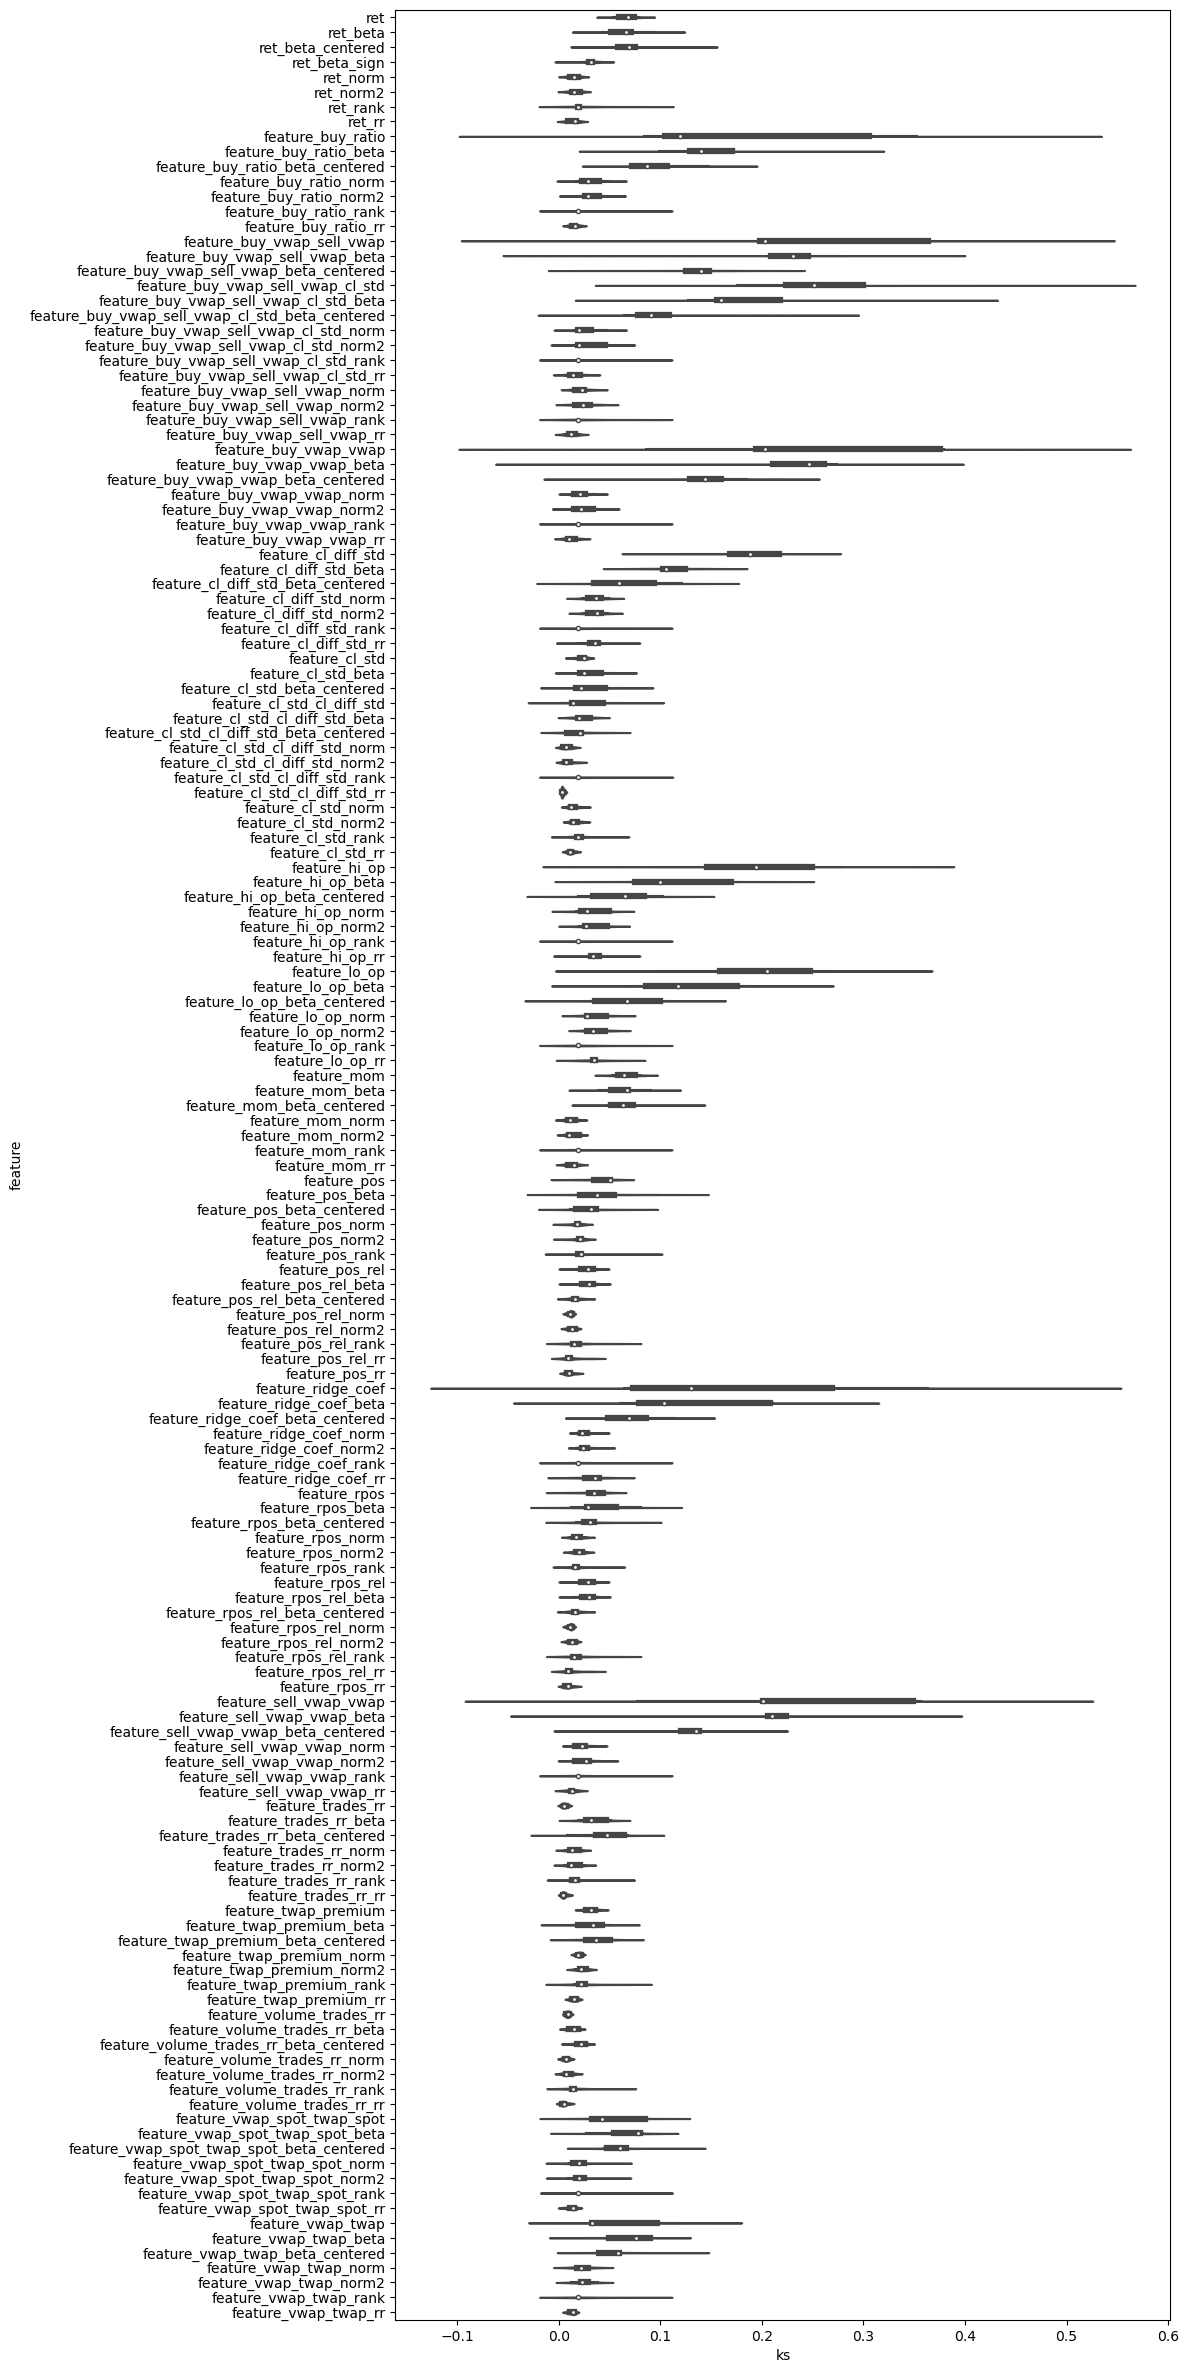

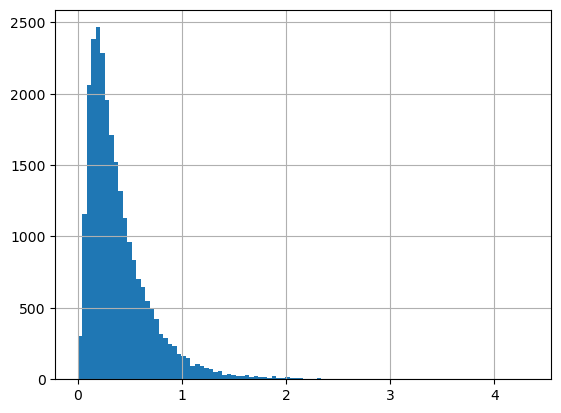

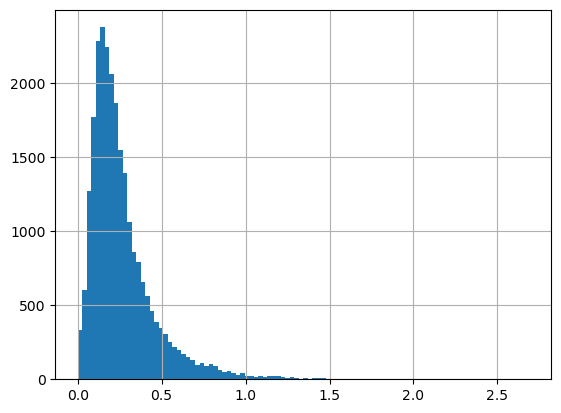

100%|██████████| 8/8 [00:00<00:00, 13.66it/s]


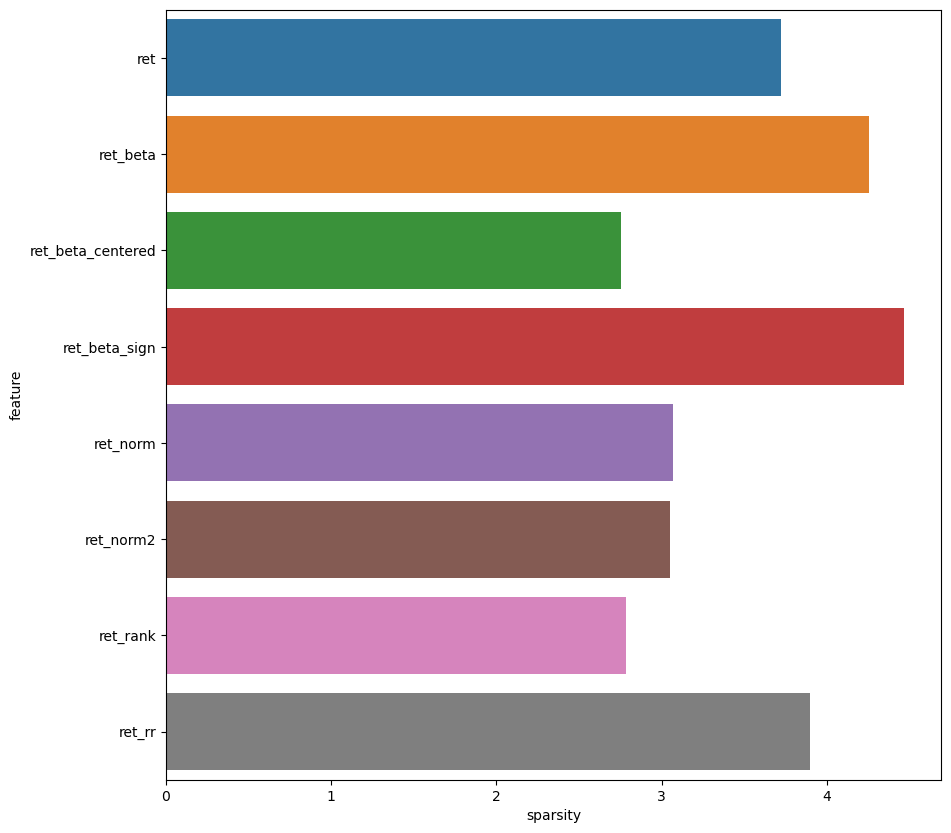

 75%|███████▌  | 6/8 [00:00<00:00,  6.86it/s]/tmp/ipykernel_30220/1105331220.py:106: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (k * np.log(np.trace(cov) / k) - np.log(np.linalg.det(cov)))
/tmp/ipykernel_30220/1105331220.py:106: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * (k * np.log(np.trace(cov) / k) - np.log(np.linalg.det(cov)))
100%|██████████| 8/8 [00:00<00:00,  9.11it/s]


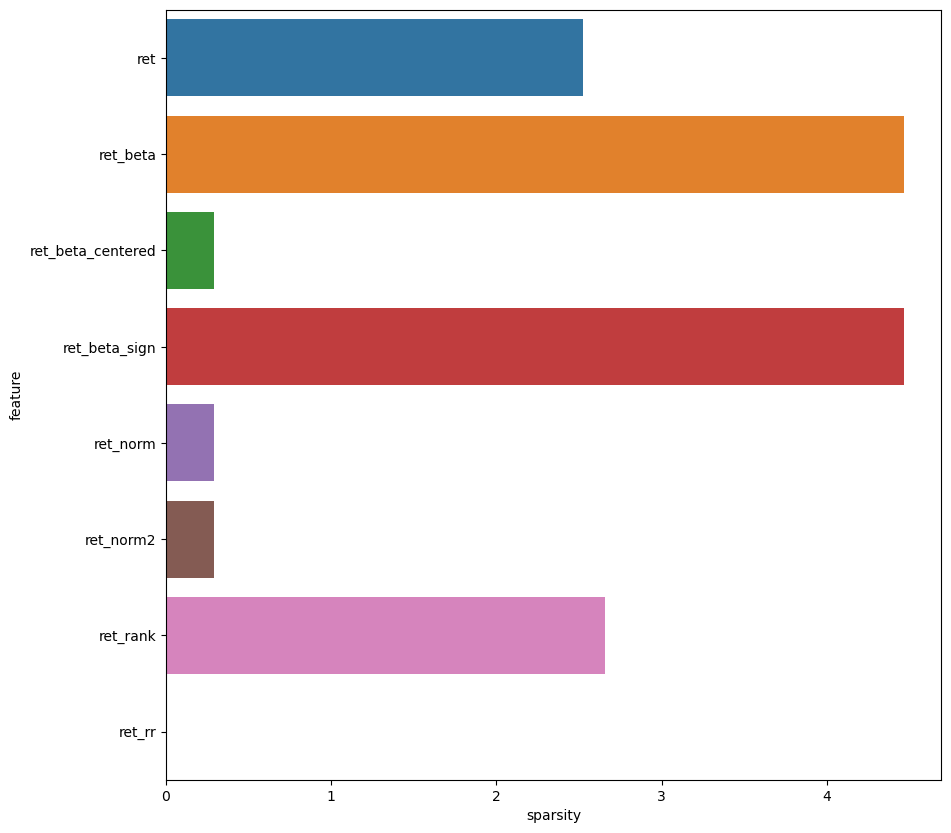

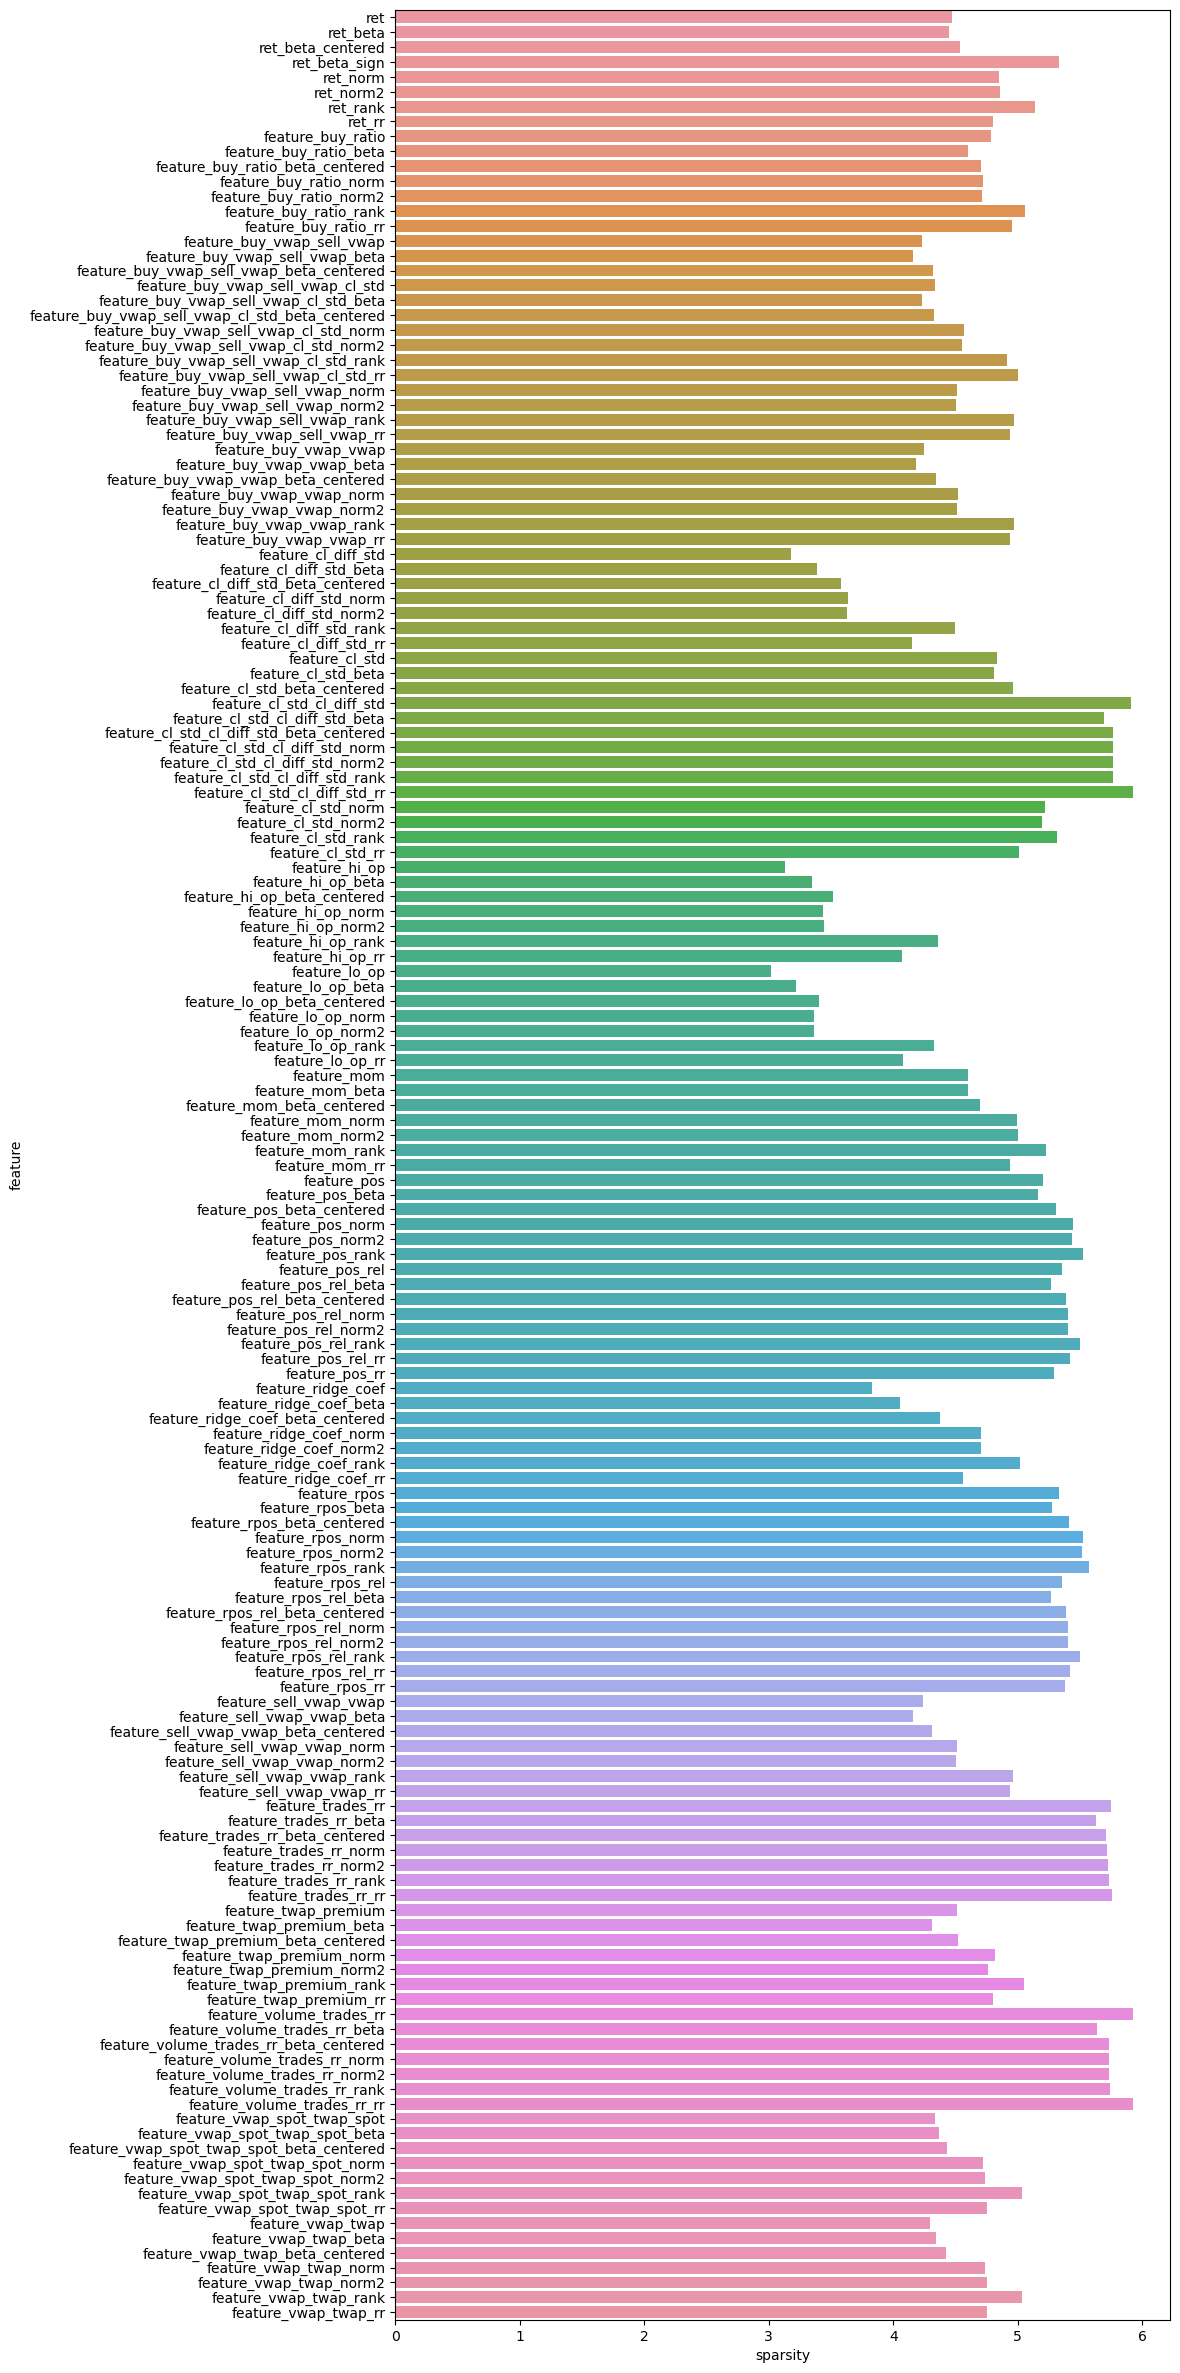

In [270]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')

df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2020-01-01 00:00:00Z')]
# df = df.loc[df.index.get_level_values('symbol') != 'BTC']

horizon = 24
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-horizon - 1) / x.shift(-1) - 1).fillna(0)

# btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

@my_cache
def beta_mean(ser):
    # broadcast btc value
    idx = ser.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(ser.loc[idx].values, index=df.index)
    # return ser.groupby('timestamp').transform('mean')
    
df['ln_cl'] = np.log(df['cl'])
df['ln_cl_diff'] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.diff(1).fillna(0))
df['ln_cl_diff_mean'] = beta_mean(df['ln_cl_diff'])
beta_window = 24 * 30
df['beta'] = (
    (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
).fillna(0).clip(0.1, 2.0)
df['beta'] = 1.0

df['cl_rel'] = np.exp(df['ln_cl'] - beta_mean(df['ln_cl']) * df['beta'])

df['vwap'] = df['amount'] / df['volume']
df['buy_vwap'] = df['buy_amount'] / df['buy_volume']
df['sell_vwap'] = (df['amount'] - df['buy_amount']) / (df['volume'] - df['buy_volume'])

df['vwap_spot'] = df['amount_spot'] / df['volume_spot']

df['feature_mom'] = np.log(df['cl']).groupby('symbol').diff(24).fillna(0)
# df['feature_mom_rel'] = np.log(df['cl_rel']).groupby('symbol').diff(24).fillna(0)

df['feature_rpos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)
df['feature_rpos_rel'] = np.log(df['cl_rel']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

def pos(x, w):
    hi = x.rolling(w).max()
    lo = x.rolling(w).min()
    return (x - lo) / (hi - lo + 1e-37)
df['feature_pos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0)
df['feature_pos_rel'] = np.log(df['cl_rel']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

df['feature_hi_op'] = (df['hi_op_max'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_lo_op'] = (df['lo_op_min'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

df['feature_cl_std'] = (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean().rolling(24 * 2).rank(pct=True)).fillna(0)
df['feature_cl_diff_std'] = (df['cl_diff_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_cl_std_cl_diff_std'] = df['cl_std'] / df['cl_diff_std']

df['feature_buy_ratio'] = df['buy_volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean())
df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_trades_rr'] = df['trades'].groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)
df['feature_volume_trades_rr'] = (df['volume'] / df['trades']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

df['feature_buy_vwap_vwap'] = np.log(df['buy_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_sell_vwap_vwap'] = np.log(df['sell_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_buy_vwap_sell_vwap'] = np.log(df['buy_vwap'] / df['sell_vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_buy_vwap_sell_vwap_cl_std'] = df['feature_buy_vwap_sell_vwap'] / (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean().rolling(24 * 2).rank(pct=True)).fillna(0)
df['feature_vwap_spot_twap_spot'] = np.log(df['vwap_spot'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

@my_cache
def calc_ridge_coef(df):
    model = RidgeCV(fit_intercept=False)
    df_x = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='cl'
    )
    df_x = (df_x / df_x.shift(1) - 1).fillna(0)
    x = df_x.values
    y = np.mean(x, axis=1)
    coef = x * 0.0
    w = 24
    for i in range(w, df_x.shape[0]):
        model.fit(x[i - w:i - 1], y[i - w:i - 1])
        coef[i, :] = model.coef_
    df_coef = df_x.copy()
    df_coef.loc[:] = coef
    df_coef = df_coef.stack()
    df['feature_ridge_coef'] = df_coef.loc[df.index].fillna(0)
calc_ridge_coef(df)

for col in ['ret'] + get_feature_columns(df):
    df[col] = df[col].fillna(0)
    df[col + '_beta'] = df[col] - beta_mean(df[col]) * df['beta']
    df[col + '_beta_centered'] = df[col + '_beta'] - df[col + '_beta'].groupby('timestamp').transform('mean')
    df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
    df[col + '_rr'] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).rank(pct=True)).fillna(0)
    norm = df[col] - df.groupby('timestamp')[col].transform('mean')
    df[col + '_norm'] = norm / (1e-37 + norm.abs().groupby('timestamp').transform('mean'))
    df[col + '_norm2'] = norm / (1e-37 + (norm ** 2).groupby('timestamp').transform('mean')) ** 0.5

df['ret_beta_sign'] = np.sign(df['ret_beta'])

# df = df.loc[df.index.get_level_values('symbol') != 'BTC']

ret_columns = sorted([x for x in df.columns if x.startswith('ret')])
df_result = calc_dist_shift_ks_single(df[ret_columns + get_feature_columns(df)].fillna(0))
# df_result = calc_dist_shift_normal_js_single(df[get_feature_columns(df)].fillna(0))
plt.figure(figsize=(10, 30))
# sns.violinplot(df_result, x='div', y='feature')
sns.violinplot(df_result, x='ks', y='feature')
# plt.xlim([-3, 3])
plt.show()

# div_mean = df_result.groupby('feature')['div'].mean()
# div_mean = df_result.groupby('feature')['ks'].mean()
# features = div_mean[div_mean < 0.1].index

df['ret'].abs().groupby('timestamp').sum().hist(bins=100)
plt.show()
df['ret_beta'].abs().groupby('timestamp').sum().hist(bins=100)
plt.show()

df_result = calc_sparsity_single(df[ret_columns])
plt.figure(figsize=(10, 10))
sns.barplot(df_result, x='sparsity', y='feature')
plt.show()
df_result = calc_sparsity_single(np.sign(df[ret_columns]))
plt.figure(figsize=(10, 10))
sns.barplot(df_result, x='sparsity', y='feature')
plt.show()

df_result = calc_sparsity2_single(df[ret_columns + get_feature_columns(df)])
plt.figure(figsize=(10, 30))
sns.barplot(df_result, x='sparsity', y='feature')
plt.show()

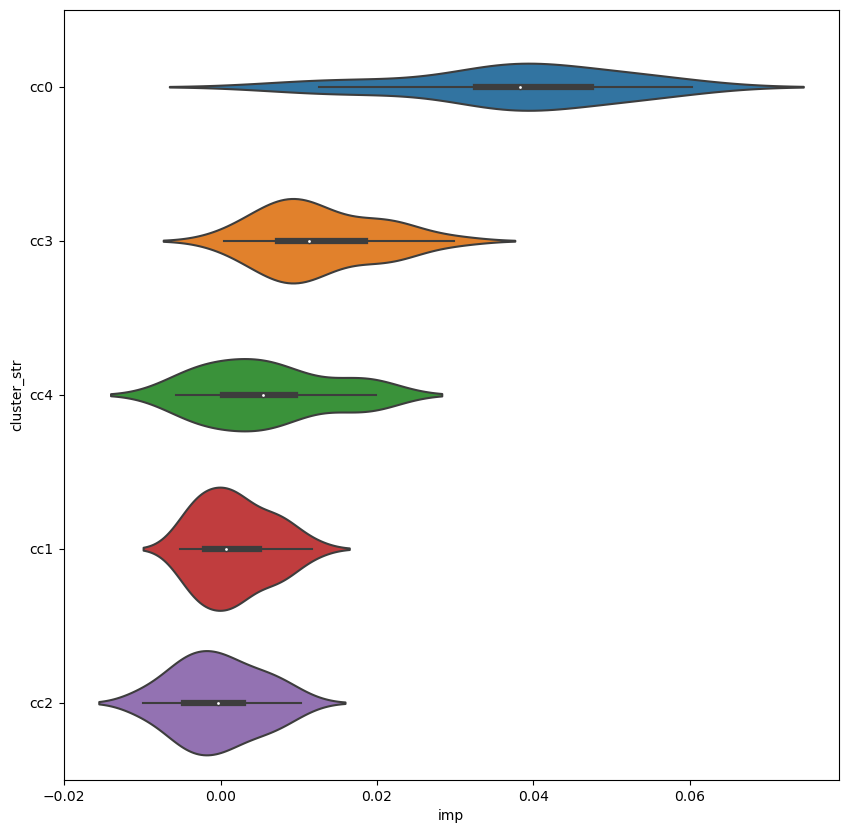

0 ['feature_buy_ratio' 'feature_mom' 'feature_pos' 'feature_pos_rel'
 'feature_rpos' 'feature_rpos_rel' 'feature_vwap_spot_twap_spot'
 'feature_vwap_twap']
1 ['feature_cl_std' 'feature_cl_std_cl_diff_std' 'feature_trades_rr'
 'feature_twap_premium' 'feature_volume_trades_rr']
2 ['feature_buy_vwap_sell_vwap' 'feature_buy_vwap_sell_vwap_cl_std'
 'feature_buy_vwap_vwap']
3 ['feature_lo_op' 'feature_sell_vwap_vwap']
4 ['feature_cl_diff_std' 'feature_hi_op']


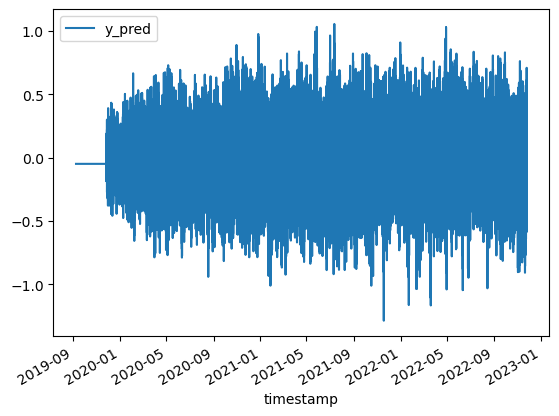

-20.87567947643343


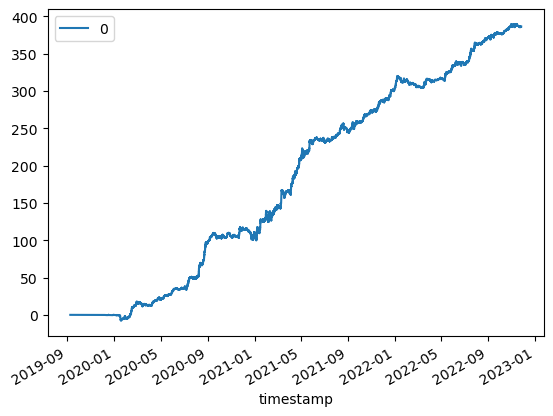

sharpe 0.041880922369345715


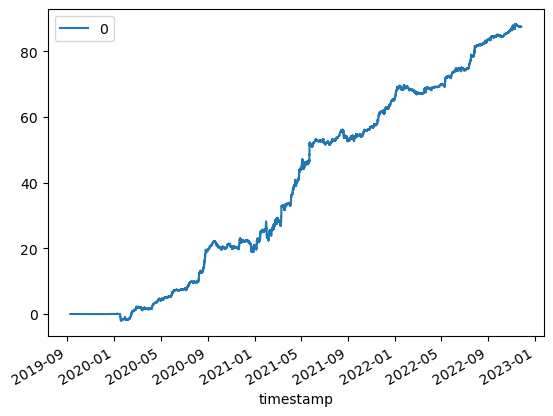

sharpe 0.04239479196241256


In [154]:


df = pd.read_pickle('/tmp/df_binance_ohlcv_with_spot.pkl')
# df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')

horizon = 24
df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-horizon - 1) / x.shift(-1) - 1).fillna(0)

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

def beta_mean(df, col):
    # broadcast btc value
    # idx = df.index.to_frame()
    # idx['symbol'] = 'BTC'
    # idx = pd.MultiIndex.from_frame(idx)
    # return pd.Series(df.loc[idx, col].values, index=df.index)
    return df.groupby('timestamp')[col].transform('mean')

df['cl_rel'] = df['cl'] / beta_mean(df, 'cl')
df['ret'] -= beta_mean(df, 'ret')

df['vwap'] = df['amount'] / df['volume']
df['buy_vwap'] = df['buy_amount'] / df['buy_volume']
df['sell_vwap'] = (df['amount'] - df['buy_amount']) / (df['volume'] - df['buy_volume'])

df['vwap_spot'] = df['amount_spot'] / df['volume_spot']

df['feature_mom'] = np.log(df['cl']).groupby('symbol').diff(24).fillna(0)
# df['feature_mom_rel'] = np.log(df['cl_rel']).groupby('symbol').diff(24).fillna(0)

df['feature_rpos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)
df['feature_rpos_rel'] = np.log(df['cl_rel']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

def pos(x, w):
    hi = x.rolling(w).max()
    lo = x.rolling(w).min()
    return (x - lo) / (hi - lo + 1e-37)
df['feature_pos'] = np.log(df['cl']).groupby('symbol').transform(lambda x: pos(x, 24)).fillna(0)
df['feature_pos_rel'] = np.log(df['cl_rel']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

df['feature_hi_op'] = (df['hi_op_max'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_lo_op'] = (df['lo_op_min'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

df['feature_cl_std'] = (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean().rolling(24 * 2).rank(pct=True)).fillna(0)
df['feature_cl_diff_std'] = (df['cl_diff_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_cl_std_cl_diff_std'] = df['cl_std'] / df['cl_diff_std']

df['feature_buy_ratio'] = df['buy_volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean()) / df['volume'].groupby('symbol').transform(lambda x: x.rolling(24).mean())
df['feature_vwap_twap'] = np.log(df['vwap'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_trades_rr'] = df['trades'].groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)
df['feature_volume_trades_rr'] = (df['volume'] / df['trades']).groupby('symbol').transform(lambda x: x.rolling(24).rank(pct=True)).fillna(0)

df['feature_buy_vwap_vwap'] = np.log(df['buy_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_sell_vwap_vwap'] = np.log(df['sell_vwap'] / df['vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_buy_vwap_sell_vwap'] = np.log(df['buy_vwap'] / df['sell_vwap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)
df['feature_buy_vwap_sell_vwap_cl_std'] = df['feature_buy_vwap_sell_vwap'] / (df['cl_std'] / df['twap']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

df['feature_twap_premium'] = np.log(df['twap'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean().rolling(24 * 2).rank(pct=True)).fillna(0)
df['feature_vwap_spot_twap_spot'] = np.log(df['vwap_spot'] / df['twap_spot']).groupby('symbol').transform(lambda x: x.rolling(24).mean()).fillna(0)

def calc_ridge_coef(df):
    model = RidgeCV(fit_intercept=False)
    df_x = df.reset_index().pivot(
        index='timestamp',
        columns='symbol',
        values='cl'
    )
    df_x = (df_x / df_x.shift(1) - 1).fillna(0)
    x = df_x.values
    y = np.mean(x, axis=1)
    coef = x * 0.0
    w = 24
    for i in range(w, df_x.shape[0]):
        model.fit(x[i - w:i - 1], y[i - w:i - 1])
        coef[i, :] = model.coef_
    df_coef = df_x.copy()
    df_coef.loc[:] = coef
    df_coef = df_coef.stack()
    df['feature_ridge_coef'] = df_coef.loc[df.index].fillna(0)
# calc_ridge_coef(df)

for col in get_feature_columns(df):
    # df[col] = np.sign(df[col] - beta_mean(df, col)).fillna(0)
    # df[col] = (df[col] - beta_mean(df, col)).fillna(0)
    # df[col] /= 1e-37 + df[col].abs().groupby('timestamp').transform('sum')
    # df[col] /= 1e-37 + df[col].abs().groupby('timestamp').transform('mean')
    
    df[col] = (df[col] - beta_mean(df, col)).fillna(0)
    df[col] = df[col] / (1e-37 + (df[col] ** 2).groupby('timestamp').transform('mean')) ** 0.5
    
    # df[col] = df[col].fillna(0)
    # df[col + '_beta'] = df[col] - beta_mean(df, col)
    # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
    # df[col + '_rr'] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).rank(pct=True)).fillna(0)
    
    # df[col + '_beta'] = np.sign(df[col + '_beta'])
    # df[col + '_rank'] = np.sign(df[col + '_rank'])
    
    # df[col + '_beta'] -= df[col + '_beta'].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).mean()).fillna(0)
    # df[col + '_hp'] = df[col] - df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 7, 1).mean()).fillna(0)
    # df[col] -= df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 2, 1).mean()).fillna(0)
    # df[col + '_beta'] -= df[col + '_beta'].groupby('symbol').transform(lambda x: x.rolling(24 * 2, 1).mean()).fillna(0)
    # df[col] = df[col].groupby('symbol').transform(lambda x: x.rolling(24 * 2, 1).rank(pct=True)).fillna(0)
    # df[col + '_beta'] = df[col + '_beta'].groupby('symbol').transform(lambda x: x.rolling(24 * 2, 1).rank(pct=True)).fillna(0)

# df = df.loc[df.index.get_level_values('symbol') != 'BTC']

def loss2(y_true, y_pred):
    # 0.5 * (np.sign(y_true) - y_pred) ** 2 * np.abs(y_true)
    grad = (y_pred * np.abs(y_true) - y_true)
    hess = np.abs(y_true) * np.ones_like(y_true)
    return grad, hess

# model = Ridge(alpha=1e5)
model = lgb.LGBMRegressor(
    # n_estimators=100,
    # learning_rate=0.01,
    # extra_trees=True,
    # colsample_bytree=0.5,
    # subsample=0.5,
    # subsample_freq=1,
    # boosting='rf',
    random_state=1,
    n_jobs=-1,
    objective=loss2,
)

model = Pipeline([
    # ('ss', StandardScaler()),
    ('model', model)
])

features = get_feature_columns(df)
df['y'] = df['ret']

scores = []
# scoring = 'r2'

def scoring(y_true, y_pred):
    ret = np.sign(y_pred) * y_true
    sharpe = np.mean(ret) / np.std(ret)
    return sharpe
    # return -np.exp(-100 * sharpe)
scoring = make_scorer(scoring, greater_is_better=True)

# qt = QuantileTransformer(output_distribution='uniform', random_state=1)
# df[get_feature_columns(df)] = qt.fit_transform(df[get_feature_columns(df)])

clustering = FeatureAgglomeration(n_clusters=5)
clustering.fit(df[get_feature_columns(df)])

cv = KFold()
rows = []
rs = np.random.RandomState(1)
for train_idx, test_idx in cv.split(df):
    train_idx = df.index[train_idx]
    test_idx = df.index[test_idx]
    model.fit(df.loc[train_idx, features].values, df.loc[train_idx, 'y'])
    
    X = df.loc[test_idx, features].values
    y = df.loc[test_idx, 'y'].values
    base_score = scoring(model, X, y)
    for i in range(clustering.n_clusters_):
        feature_idx = np.arange(X.shape[1])[clustering.labels_ == i]
        for j in range(5):
            X2 = X.copy()
            X2[:, feature_idx] = X2[:, feature_idx][rs.permutation(np.arange(X2.shape[0]))]
            score = scoring(model, X2, y)
            rows.append({
                'cluster': 'c' + str(i),
                'imp': base_score - score,
            })

    df.loc[test_idx, 'y_pred'] = model.predict(df.loc[test_idx, features].values)

df_result = pd.DataFrame(rows)
df_result['imp_mean'] = df_result.groupby('cluster')['imp'].transform('mean')
df_result = df_result.sort_values('imp_mean', ascending=False)

plt.figure(figsize=(10, 10))
df_result['cluster_str'] = 'c' + df_result['cluster'].astype('str')
sns.violinplot(df_result, x='imp', y='cluster_str')
plt.show()

for i in range(clustering.n_clusters_):
    feature_idx = np.arange(X.shape[1])[clustering.labels_ == i]
    print(i, np.array(features)[feature_idx])

df['y_pred'].reset_index(level='symbol').plot()
plt.show()

print(r2_score(df['y'], df['y_pred']))

# scales = np.linspace(0, 1, 100)
# for s in scales:
#     print(s, r2_score(df['y'], df['y_pred'] * s))

ret = np.sign(df['y_pred']) * df['ret']
ret.cumsum().reset_index(level='symbol').plot()
plt.show()
print('sharpe {}'.format(ret.mean() / ret.std()))

ret = df['y_pred'] * df['ret']
ret.cumsum().reset_index(level='symbol').plot()
plt.show()
print('sharpe {}'.format(ret.mean() / ret.std()))